In [68]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""
#del F
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
import pickle
import os

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width, depth, kernz):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.depth = depth
        self.kernelsize = kernz
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width, bias=False) # input channel is 2: (a(x), x)
        
        self.fouriers = nn.ModuleList([SpectralConv1d(self.width, self.width, self.modes1) for i in range(self.depth)])
        self.convs = nn.ModuleList([nn.Conv1d(self.width, self.width, self.kernelsize, padding = int(self.kernelsize/2)) for i in range(self.depth)])


        self.relu = nn.GELU()


        self.fc1 = nn.Linear(self.width, 128,  bias=False)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        
        x = torch.cat((x, grid), dim=-1)
        #print(x.shape)
        x = self.fc0(x)
        #print(x.shape)
        x = x.permute(0, 2, 1)
        #print(x.shape)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        
        for i in range(self.depth):
            
            x1 = self.fouriers[i](x)
            x2 = self.convs[i](x)
            
            x = self.relu(x1 + x2)
            #x = self.relu(x1)

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        

        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 100
learning_rate = 0.001

epochs = 1000
step_size = 50
gamma = 0.5

modes = 1 #16
width = 64


In [69]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)


for datas in ['TRAIN']:

    batch_size = 40

    with open("./data/" + datas + ".pickle","rb") as fr:
        train_raw_set_loaded = pickle.load(fr)
    
    if datas == 'TRAIN' or datas == 'Burger_GRF_0.01_50000':
        with open("./data/TEST.pickle","rb") as fr:
            test_raw_set_loaded = pickle.load(fr)
    elif datas == 'Burger_vicious_GRF_0.05_10000' or datas == 'Burger_vicious_GRF_0.05_800':
        with open("./data/Burger_vicious_GRF_0.05_test.pickle","rb") as fr:
            test_raw_set_loaded = pickle.load(fr)
    elif datas == '1d_Heat_GRF_0.05_10000_1024':
        with open("./data/1d_Heat_GRF_0.05_200_1024.pickle","rb") as fr:
            test_raw_set_loaded = pickle.load(fr)
    elif datas == 'Integration_GRF_0.05_10000':
        with open("./data/Integration_GRF_0.05_test.pickle","rb") as fr:
            test_raw_set_loaded = pickle.load(fr)
    elif datas == 'new_KdV_GRF_0.05_10000': 
        with open("./data/new_KdV_GRF_0.05_test.pickle","rb") as fr:
            test_raw_set_loaded = pickle.load(fr)
    else:
        with open("./data/Burger_GRF_0.05_test.pickle","rb") as fr:
            test_raw_set_loaded = pickle.load(fr)
    
    
    x_train = torch.tensor(train_raw_set_loaded['train_X'])
    y_train = torch.tensor(train_raw_set_loaded['train_Y'])
    x_test = torch.tensor(test_raw_set_loaded['train_X'])
    y_test = torch.tensor(test_raw_set_loaded['train_Y'])

    y_train = y_train.unsqueeze(-1)
    y_test = y_test.unsqueeze(-1)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=100, shuffle=False)


In [70]:


re = 3

model = FNO1d(10, 64, 5, 1).cuda()

print(count_params(model))

ntrain = len(x_train)
ntest = len(x_test)
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=re*1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
myloss2 = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        #mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        #train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()


            out = model(x)
            test_l2 += myloss2(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    #train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    print(ep, train_l2, test_l2)

    t2 = default_timer()

438913
0 0.40001300811767576 0.6633986790974935
1 0.3999119758605957 0.6637911478678385
2 0.3994770876566569 0.6602771123250325
3 0.3975738016764323 0.6413984298706055
4 0.3950950558980306 0.6443891525268555
5 0.39494261423746746 0.6407592137654622
6 0.394173043568929 0.6419220606486002
7 0.394075984954834 0.6415449778238932
8 0.3941551653544108 0.6412797292073568
9 0.39378650665283205 0.6417367935180665
10 0.39428340911865234 0.6454751332600911
11 0.39388925552368165 0.6410519917805989
12 0.39266619364420574 0.644377326965332
13 0.3927576955159505 0.6414358774820964
14 0.3929963493347168 0.6399726867675781
15 0.39235118865966795 0.6447163899739583
16 0.3915058135986328 0.6414761225382487
17 0.3916852569580078 0.6409284591674804
18 0.39105278650919595 0.6403893788655599
19 0.3911190668741862 0.6420474370320638
20 0.3908868662516276 0.641172726949056
21 0.3905950101216634 0.6433177947998047
22 0.39004971186319987 0.6437576293945313
23 0.3901108423868815 0.6430952707926433
24 0.389000358

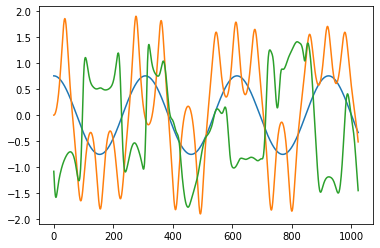

In [72]:
plt.plot(x[0][:,1].cpu())
plt.plot(x[0][:,0].cpu())
plt.plot(out[1][:,0].cpu())

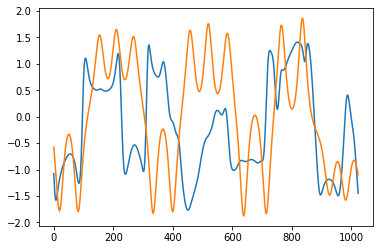

In [73]:
plt.plot(out[1][:,0].cpu())
plt.plot(x[1][:,0].cpu())